# Born offset extended

## Import modules

In [1]:
# Basic stuff
import sys
sys.path.append("/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time

# Plotting library
import matplotlib.pyplot as plt
import sepPlot

## Wavelet (sources)

In [2]:
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/waveletMain.py timeDelay=1.0 f1=2 f2=5 f3=8 f4=15 par=parBorn.p type=ali wavelet=waveletBornExt.H

## Velocity models (true and background)

In [3]:
# True velocity model
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousi.H data=velocityMarmousi.pad.H

# Background velocity model
!Smooth rect1=10 rect2=10 < velocityMarmousi.H > velocityMarmousiSmooth.H
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousiSmooth.H data=velocityMarmousiSmooth.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Model (extended reflectivity)

In [4]:
# Create an extended reflectivity
!Spike n1=350 n2=1700 d1=1.0 d2=1.0 n3=1 d3=1.0 velback=0.0 nsp=1 mag=0.01 k1=250 k2=850 > junk.H
!Pad beg3=5 end3=15 extend=0 < junk.H > modelBornOffset.H
!echo "d1=0.01 d2=0.01 d3=0.01 o1=0.0 o2=0.0 o3=-0.1" >> modelBornOffset.H

# Pad extended reflectivity
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=modelBornOffset.H data=modelBornOffset.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Initialize Born extended (offset) operator

In [5]:
args=["dummy arg","vel=velocityMarmousiSmooth.pad.H","sources=waveletBornExt.H","par=parBornExt.p","model=modelBornOffset.pad.H","extension=offset","nExt=21"]
modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector=Acoustic_iso_double.BornExtOpInitDouble(args)

# Printing parameter file for reference
!cat parBornExt.p

nts=1000
dts=0.008
sub=8
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=20
zSource=2
xSource=850
nShot=1
spacingShots=10
depthReceiver=2
nReceiver=1700
dReceiver=1
oReceiver=1
blockSize=16
fat=5
nGpu=8


## Create Born extended object

In [6]:
BornOffsetOp=Acoustic_iso_double.BornExtShotsGpu(modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector)


## Read model (extended reflectivity)

In [9]:
modelFile=parObject.getString("model")
modelFloat=genericIO.defaultIO.getVector(modelFile,ndims=3)
modelDouble=SepVector.getSepVector(modelFloat.getHyper(),storage="dataDouble")
modelDMat=modelDouble.getNdArray()
modelSMat=modelFloat.getNdArray()
modelDMat[:]=modelSMat

## Born offset extended forward

In [10]:
BornOffsetOp.forward(False,modelDouble,dataDouble)

## Born offset extended adjoint

In [11]:
# Create a model vector for adjoint result
modelAdjDouble=SepVector.getSepVector(modelDouble.getHyper(),storage="dataDouble")

# Apply adjoint
BornOffsetOp.adjoint(False,modelAdjDouble,dataDouble)

## Display results

### Forward

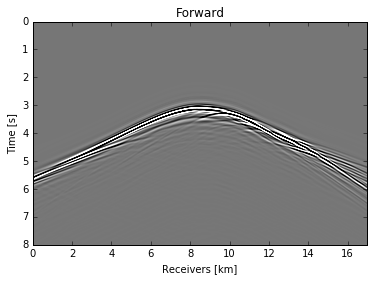

In [13]:
# Convert data to 2D float 
dataFloat2D=SepVector.getSepVector(Hypercube.hypercube(axes=[dataDouble.getHyper().axes[0],dataDouble.getHyper().axes[1]]))
dataFloat2DNd=dataFloat2D.getNdArray()
dataDoubleNd=dataDouble.getNdArray()
dataFloat2DNd[:]=dataDoubleNd

# Plot forward
sepPlot.Grey(plt,dataFloat2D,label1="Time [s]",label2="Receivers [km]",title="Forward").output()

### Adjoint

NameError: name 'animation' is not defined

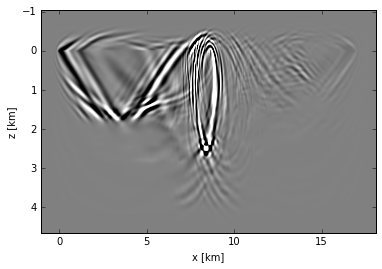

In [14]:
# Plot adjoint
sepPlot.Grey(plt,modelAdjDouble,label1="z [km]",label2="x [km]",title="Model").output()

## Write results to disk

In [15]:
# Data 
dataFloat=SepVector.getSepVector(dataDouble.getHyper(),storage="dataFloat")
dataFloatNp=dataFloat.getNdArray()
dataDoubleNp=dataDouble.getNdArray()
dataFloatNp[:]=dataDoubleNp
_=genericIO.defaultIO.writeVector("BornOffsetFwdJupyter.H",modelFloat)

# Model after applying FWD and ADJ
modelFloat=SepVector.getSepVector(modelAdjDouble.getHyper(),storage="dataFloat")
modelFloatNp=modelAdjDouble.getNdArray()
modelDoubleNp=modelAdjDouble.getNdArray()
modelFloatNp[:]=modelDoubleNp
_=genericIO.defaultIO.writeVector("BornOffsetAdjJupyter.H",modelFloat)

# Dot product test

In [16]:
BornOffsetOp.dotTest(True)

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
	Runs in: 4.510986566543579 seconds
Applying adjoint operator add=False
	Runs in: 20.34583020210266 seconds
Dot products add=False: domain=-3.935485122748255e-06 range=-3.935485122748026e-06 
Absolute error: 2.295459287059154e-19
Relative error: 5.83272256269211e-14 


Applying forward operator add=True
	Runs in: 4.983800649642944 seconds
Applying adjoint operator add=True
	Runs in: 20.878707885742188 seconds
Dot products add=True: domain=-7.870970245496495e-06 range=-7.870970245495951e-06 
Absolute error: 5.437951521372608e-19
Relative error: 6.908870636989635e-14 

-------------------------------------------------
